# Activty Algorithm Development

In [33]:
# Machine learning classification functions
# Arnulf Graf/Lucas Selig/Steve DiCristafaro (2021)

import sys
import numpy as np
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, Binarizer, KBinsDiscretizer
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn import tree
from sklearn.linear_model import Perceptron, LogisticRegression, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier #brew install cmake
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam, RMSprop, SGD
# from tensorflow.keras.regularizers import l1, l2
# from tensorflow.keras.utils import to_categorical


def clf_sampling(sampling_type, X, y):
    # over- or undersampling to yield a balanced dataset
    if sampling_type == 'none':
        return X, y
    elif sampling_type == 'over_RandomOverSampler': # oversampling
        sampling = RandomOverSampler(sampling_strategy='auto', random_state=42)
    elif sampling_type == 'over_SMOTE': # oversampling
        sampling = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    elif sampling_type == 'under_RandomUnderSample': # undersampling
        sampling = RandomUnderSampler(sampling_strategy='auto', random_state=42, replacement=True)
    elif sampling_type == 'under_MearMiss': # undersampling
        sampling = NearMiss(sampling_strategy='auto', version=1, n_neighbors=3, n_neighbors_ver3=3)
    else:
        raise ValueError('Not forseen sampling algorithm')
    X_sampled, y_sampled = sampling.fit_resample(X, y)
    return X_sampled, y_sampled


class IdentityScaler(object):
    # identity scaling function
    def __init__(self, *args, **kwargs):
        pass

    def transform(self, x):
        return x


def clf_preprocessing(preprocessing_type, X):
    # preprocessing
    if preprocessing_type == 'identity':  # no scaling
        preprocessor = IdentityScaler()
    elif preprocessing_type == 'z_score':  # standardize each feature
        preprocessor = StandardScaler().fit(X)
    elif preprocessing_type == 'min_max':  # scale each feature
        preprocessor = MinMaxScaler(feature_range=(-1, +1)).fit(X)
    elif preprocessing_type == 'normalize':  # normalize each sample
        preprocessor = Normalizer(norm='l2').fit(X)
    elif preprocessing_type == 'binarize':
        preprocessor = Binarizer(threshold=0.0).fit(X)
    elif preprocessing_type == 'discretize':
        preprocessor = KBinsDiscretizer(n_bins=10).fit(X)
    else:
        raise ValueError('Not forseen preprocessing algorithm')
    X_preprocessed = preprocessor.transform(X)
    return preprocessor, X_preprocessed


def clf_train(ml_type, X, y, verbose=True):
    # training
    if ml_type == 'centroid':
        clf = NearestCentroid(metric='euclidean', shrink_threshold=None)
        clf.fit(X, y)
    elif ml_type == 'naive_bayes':
        clf = GaussianNB()
        #clf = MultinomialNB()  # use discretize as scaling
        #clf = BernoulliNB(binarize=0.0)
        clf.fit(X, y)
    elif ml_type == 'lda':
        clf = LinearDiscriminantAnalysis(solver='svd', shrinkage=None, priors=None, tol=0.0001)
        clf.fit(X, y)
    elif ml_type == 'perceptron':
        param_grid = {'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': [0.0001, 0.1, 0.5, 0.9, 1.0, 10.0, 100]}
        perceptron = Perceptron(tol=1e-3, random_state=42)
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        clf = GridSearchCV(perceptron, param_grid, cv=kfold)
        clf.fit(X, y)
        if verbose: print('Optimal params: ', clf.best_params_, ' and validation accuracy: ' + '%3.2f' % (100*clf.best_score_) + '%')
    elif ml_type == 'ridge':
        clf = RidgeClassifierCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
                                fit_intercept=True, normalize=False, scoring=None, cv=10)
        clf.fit(X, y)
        if verbose: print('Optimal params: ', clf.alpha_, ' and validation accuracy: ' + '%3.2f' % (100*clf.best_score_) + '%')
    elif ml_type == 'logistic_regression':
        param_grid = {'penalty': ['l1', 'l2'], 'C': [1e-2, 1e-1, 1, 1e1, 1e2]}
        # param_grid = {'penalty': ['l2'], 'C': [1]}
        lr = LogisticRegression(solver='saga', tol=0.0001, max_iter=1e4, random_state=42)
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        clf = GridSearchCV(lr, param_grid, cv=kfold, verbose=3)
        clf.fit(X, y)
        if verbose: print('Optimal params: ', clf.best_params_, ' and validation accuracy: ' + '%3.2f' % (100*clf.best_score_) + '%')
    elif ml_type == 'qda':
        param_grid = {'reg_param': [0, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1]}
        qda = QuadraticDiscriminantAnalysis(priors=None, store_covariance=False, tol=0.0001)
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        clf = GridSearchCV(qda, param_grid, cv=kfold, n_jobs=-1, verbose=1)
        clf.fit(X, y)
        if verbose: print('Optimal params: ', clf.best_params_, ' and validation accuracy: ' + '%3.2f' % (100*clf.best_score_) + '%')

    elif ml_type == "decision_tree":
        param_grid = {'max_depth': [1], 'criterion': ["gini", "entropy"]}
        dt = tree.DecisionTreeClassifier(random_state=4, class_weight="balanced")
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        clf = GridSearchCV(dt, param_grid, cv=kfold, n_jobs=-1, verbose=3)
        clf.fit(X, y)
        if verbose: print('Optimal params: ', clf.best_params_, ' and validation accuracy: ' + '%3.2f' % (100*clf.best_score_) + '%')

    elif ml_type == 'random_forest':
        param_grid = {'n_estimators': [100, 200, 1000], 'max_depth': [1, 10, None], 'criterion': ['gini', 'entropy']}
        rf = RandomForestClassifier(random_state=42, n_jobs=-1)
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        clf = GridSearchCV(rf, param_grid, cv=kfold, n_jobs=-1, verbose=3)
        clf.fit(X, y)
        if verbose: print('Optimal params: ', clf.best_params_, ' and validation accuracy: ' + '%3.2f' % (100*clf.best_score_) + '%')
    elif ml_type == 'svm_lin':
        param_grid = {'C': 10.0 ** np.arange(-1, 2, 1)}
        #svc = LinearSVC(class_weight='balanced', max_iter=1e5)
        svc = SVC(kernel='linear', class_weight='balanced')
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        clf = GridSearchCV(svc, param_grid, cv=kfold, verbose = 3)
        clf.fit(X, y)
        if verbose: print('Optimal params: ', clf.best_params_, ' and validation accuracy: ' + '%3.2f' % (100*clf.best_score_) + '%')
    elif ml_type == 'svm':
        param_grid = [
            {'kernel': ['linear'], 'C': 10.0 ** np.arange(0, 3, 1)}]
            # {'kernel': ['rbf'], 'C': 10.0 ** np.arange(-1, 3, 1), 'gamma': 10.0 ** np.arange(-3, 1, 1)},
        svc = SVC(class_weight='balanced')
        # clf = SVC(class_weight='balanced', kernel = "linear", C = 100.0)
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        clf = GridSearchCV(svc, param_grid, cv=kfold, verbose = 3)
        clf.fit(X, y)
        if verbose: print('Optimal params: ', clf.best_params_, ' and validation accuracy: ' + '%3.2f' % (100*clf.best_score_) + '%')
    elif ml_type == 'bagging':
        param_grid = {'n_estimators': [10, 100]}
        #bagging = BaggingClassifier(base_estimator=None, random_state=42)
        bagging = BaggingClassifier(base_estimator=SVC(C=10.0, kernel='rbf', gamma='scale'), random_state=42)
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        clf = GridSearchCV(bagging, param_grid, cv=kfold, n_jobs=-1, verbose=1)
        clf.fit(X, y)
        if verbose: print('Optimal params: ', clf.best_params_, ' and validation accuracy: ' + '%3.2f' % (100*clf.best_score_) + '%')
    elif ml_type == 'adaboost':
        param_grid = {'n_estimators': [10, 100], 'learning_rate': [0.01, 0.1, 1]}
        #adaboost = AdaBoostClassifier(base_estimator=None, algorithm='SAMME.R', random_state=42)
        #adaboost = AdaBoostClassifier(base_estimator=GaussianNB(), algorithm='SAMME.R', random_state=42)
        adaboost = AdaBoostClassifier(base_estimator=LogisticRegression(C=10), algorithm='SAMME.R', random_state=42)
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        clf = GridSearchCV(adaboost, param_grid, cv=kfold, n_jobs=-1, verbose=1)
        clf.fit(X, y)
        if verbose: print('Optimal params: ', clf.best_params_, ' and validation accuracy: ' + '%3.2f' % (100*clf.best_score_) + '%')
    elif ml_type == 'xgboost':
        param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [1, 3, 5], 'learning_rate': [0.01, 0.1, 1]}
        xgboost = XGBClassifier(random_state=42, n_jobs=-1)
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        clf = GridSearchCV(xgboost, param_grid, cv=kfold, n_jobs=-1, verbose=1)
        clf.fit(X, y)
        if verbose: print('Optimal params: ', clf.best_params_, ' and validation accuracy: ' + '%3.2f' % (100*clf.best_score_) + '%')
    elif ml_type == 'ann':
        param_grid = {'alpha': 10.0 ** np.arange(-2, 3, 1)}
        mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(100, 50), random_state=42, activation='relu')
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        clf = GridSearchCV(mlp, param_grid, cv=kfold)
        clf.fit(X, y)
        if verbose: print('Optimal params: ', clf.best_params_, ' and validation accuracy: ' + '%3.2f' % (100*clf.best_score_) + '%')
    elif ml_type == 'mlp':
        batch_size = 5
        n_epoch = 150
        ann_type = 'deep_construct'
        y = to_categorical(y)
        clf = Sequential()
        if ann_type == 'direct':
            clf.add(Dense(units=y.shape[1], input_shape=(X.shape[1], ),
                          activation='softmax'))
        elif ann_type == 'shallow':
            clf.add(Dense(units=100, input_shape=(X.shape[1], ),
                          activation='relu', kernel_initializer='normal'))
            clf.add(Dense(units=y.shape[1], activation='softmax'))
        elif ann_type == 'deep':
            clf.add(Dense(units=100, input_shape=(X.shape[1], ),
                          activation='relu', kernel_initializer='normal'))
            clf.add(Dropout(0.2))
            clf.add(Dense(units=50, activation='relu',
                          kernel_regularizer=l2(0.001)))
            clf.add(Dense(units=50, activation='sigmoid',
                          kernel_regularizer=l1(0.001)))
            clf.add(Dense(units=y.shape[1], activation='softmax'))
        elif ann_type == 'deep_construct':
            n_neur_vec = [150, 100, 50, 50]
            activation_vec = ['relu', 'relu', 'sigmoid', 'relu']
            clf.add(Dense(units=n_neur_vec[0], input_shape=(X.shape[1], ),
                          activation=activation_vec[0]))
            clf.add(Dropout(0.2))
            for n_n, act in zip(n_neur_vec[1:], activation_vec[1:]):
                clf.add(Dense(units=n_n, activation=act))
                clf.add(Dropout(0.2))
            clf.add(Dense(units=y.shape[1], activation='softmax'))
        else:
            raise ValueError('Not forseen ANN type')
        #print(clf.summary())
        #sys.exit()
        #optimizer = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False) # tune learning rate and momentum (2 hyperparameters)
        optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)  # tune learning rate (1 hyperparameter)
        #optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0) # tune learning rate (1 hyperparameter)
        clf.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        clf.fit(X, y, epochs=n_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    else:
        raise ValueError('Not forseen ML algorithm')
    if verbose: print('Training accuracy: ' + '%3.2f' % (100*accuracy_score(y, clf.predict(X))) + '%')
    return clf


def clf_test(preprocessor, clf, X):
    # preprocessing and testing
    X = preprocessor.transform(X)
    y_pred = clf.predict(X)
    if clf.__class__.__name__ in ('Sequential'):
        y_pred = np.argmax(y_pred, axis=1)
    return y_pred


# Dataset background

Feature selection, trial selectoin

Compare to old results

Fix y axis

In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os, random
from pathlib import Path

np.random.seed( 0 )
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from matplotlib import cm
from sklearn.metrics import accuracy_score


all_features = []
MODE = "binary"
if(MODE == "binary"):
    target_names = ["Inactive", "Active"]

if(MODE == "multi"):
    target_names = ["Inactive", "Low", "Mod", "High"]

# HR ACTIVITY
for trial in glob.glob("/Users/lselig/Desktop/activity_validation_hr_activity_model_dev_v2/*/"):
    # if("HR_ACTIVITY_20210630_282723_827_1" in trial):
    #     continue
    features = pd.read_parquet(trial + "/features_labels.parquet")
    all_features.append(features)


# MAS
for trial in glob.glob("/Users/lselig/Desktop/MAS/*/"):
    if("1717" in trial):
        continue
    features = pd.read_parquet(trial + "/features_labels_v2.parquet")
    all_features.append(features)

N_trials = len(all_features)

all_features = pd.concat(all_features)
print(all_features.shape)
y_df = all_features.pop(f"true_{MODE}")
if(MODE == "multi"):
    y_df = y_df.replace("high", 3)
    y_df = y_df.replace("mod", 2)
    y_df = y_df.replace("low", 1)
    y_df = y_df.replace("inactive", 0)
else:
    y_df = y_df.replace("active", 1)
    y_df = y_df.replace("inactive", 0)
# all_features["is_male"] = all_features["gender"].replace("M", 1).replace("F", 0)
X_df = all_features.drop(columns = ["etime", "gender", "height_cm", "weight_kg", "age", "true_multi" if MODE == "binary" else "true_binary"])

print(f"N trials = {N_trials}")
print(f"N windows = {X_df.shape[0]}")
print(f"N features = {X_df.shape[1]}")

(10766, 193)
N trials = 35
N windows = 10766
N features = 186


Number of training/testing samples: 8149 / 2038
Number of training samples after sampling: 8312
Train class 0 size: 3993 -> 4156
Train class 1 size: 4156 -> 4156
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Optimal params:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}  and validation accuracy: 93.78%
Training accuracy: 100.00%
Inactive -- {'precision': 0.9082483781278962, 'recall': 0.9607843137254902, 'f1-score': 0.9337779895188185, 'support': 1020}
Active -- {'precision': 0.9582898852971846, 'recall': 0.9027504911591355, 'f1-score': 0.9296914516944865, 'support': 1018}
accuracy -- 0.9317958783120707
macro avg -- {'precision': 0.9332691317125403, 'recall': 0.9317674024423128, 'f1-score': 0.9317347206066525, 'support': 2038}
weighted avg -- {'precision': 0.9332445774891992, 'recall': 0.9317958783120707, 'f1-score': 0.9317367257773219, 'support': 2038}


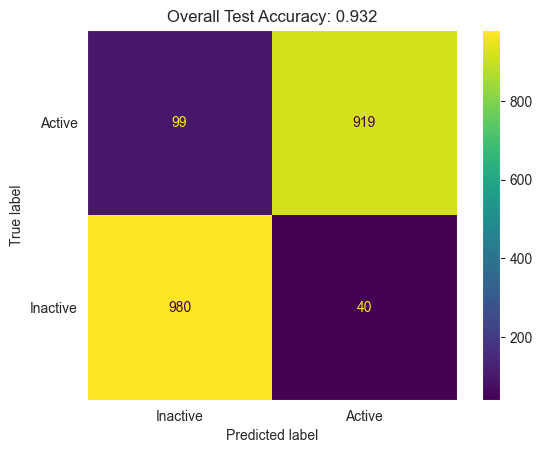

In [108]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_df), np.array(y_df), test_size = 0.2, random_state = 42)

assert (X_train.shape[0] == y_train.shape[0]), 'Number of training samples mismatch'
assert (X_test.shape[0] == y_test.shape[0]), 'Number of testing samples mismatch'
print('Number of training/testing samples:', X_train.shape[0], '/', X_test.shape[0])

# over or undersampling training set
X_train_sampled, y_train_sampled = clf_sampling('over_SMOTE', X_train, y_train)
assert (X_train_sampled.shape[0] == y_train_sampled.shape[0]), 'Number of training samples mismatch'
print('Number of training samples after sampling:', X_train_sampled.shape[0])
for i in range(len(np.unique(y_df))):
    print(f'Train class {i} size: {len(np.nonzero(y_train == i)[0])} -> {len(np.nonzero(y_train_sampled == i)[0])}')
    
# preprocessing and training (learning)
scaling_name = "identity" # no scaling for random forest
model_name = "random_forest"
# model_name = "xgboost"
preprocessor, X_train_preprocessed = clf_preprocessing(scaling_name, X_train_sampled)
clf = clf_train(model_name, X_train_preprocessed, y_train_sampled) 

# clf = tree.DecisionTreeClassifier(random_state = 4)
# clf = RandomForestClassifier(random_state = 4)
# clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

class_report = classification_report(y_test,
                                     y_pred,
                                     target_names = target_names,
                                     output_dict=True,
                                     digits=4)
for class_ in class_report:
    print(f"{class_} -- {class_report[class_]}")

conf_mat = confusion_matrix(y_test, y_pred, normalize=None)
conf_mat_norm = confusion_matrix(y_test, y_pred)
# conf_mat = conf_mat.T
# plot confusion matrix
acc = np.round(accuracy_score(y_test, y_pred), 3)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                               display_labels= target_names)
disp.plot()
plt.title(f"Overall Test Accuracy: {acc}")
plt.gca().invert_yaxis()
plt.grid(b = None)
plt.show()


# Validation on holdout data

['/Users/lselig/Desktop/MAS/MAS_11022022_1717_1/Polar_H10/', '/Users/lselig/Desktop/MAS/MAS_11022022_1717_1/Fitbit/', '/Users/lselig/Desktop/MAS/MAS_11022022_1717_1/e62116000073/']

1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
1717 MAS 1
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
wal

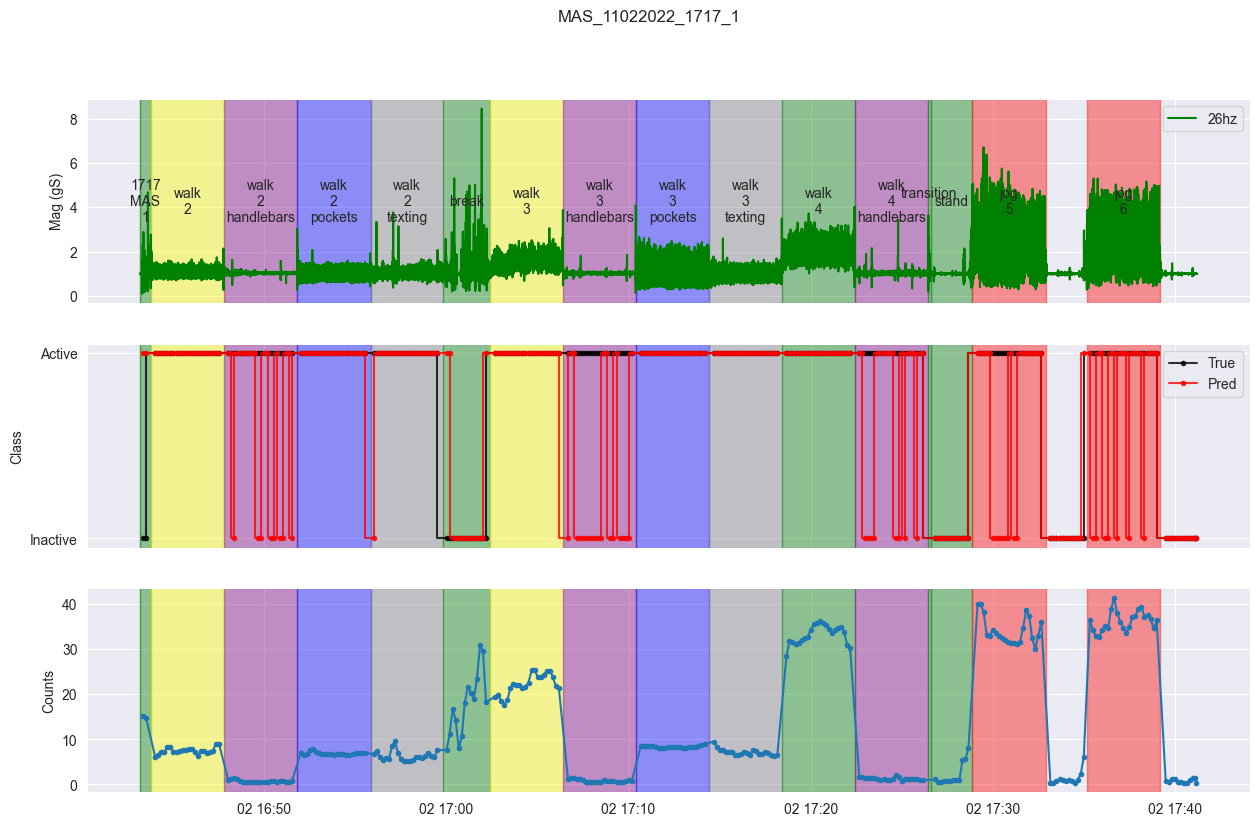

['/Users/lselig/Desktop/MAS/MAS_11022022_9922_1/Polar_H10/', '/Users/lselig/Desktop/MAS/MAS_11022022_9922_1/Fitbit/', '/Users/lselig/Desktop/MAS/MAS_11022022_9922_1/eb2116000104/']

9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
9922 MAS 1
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 

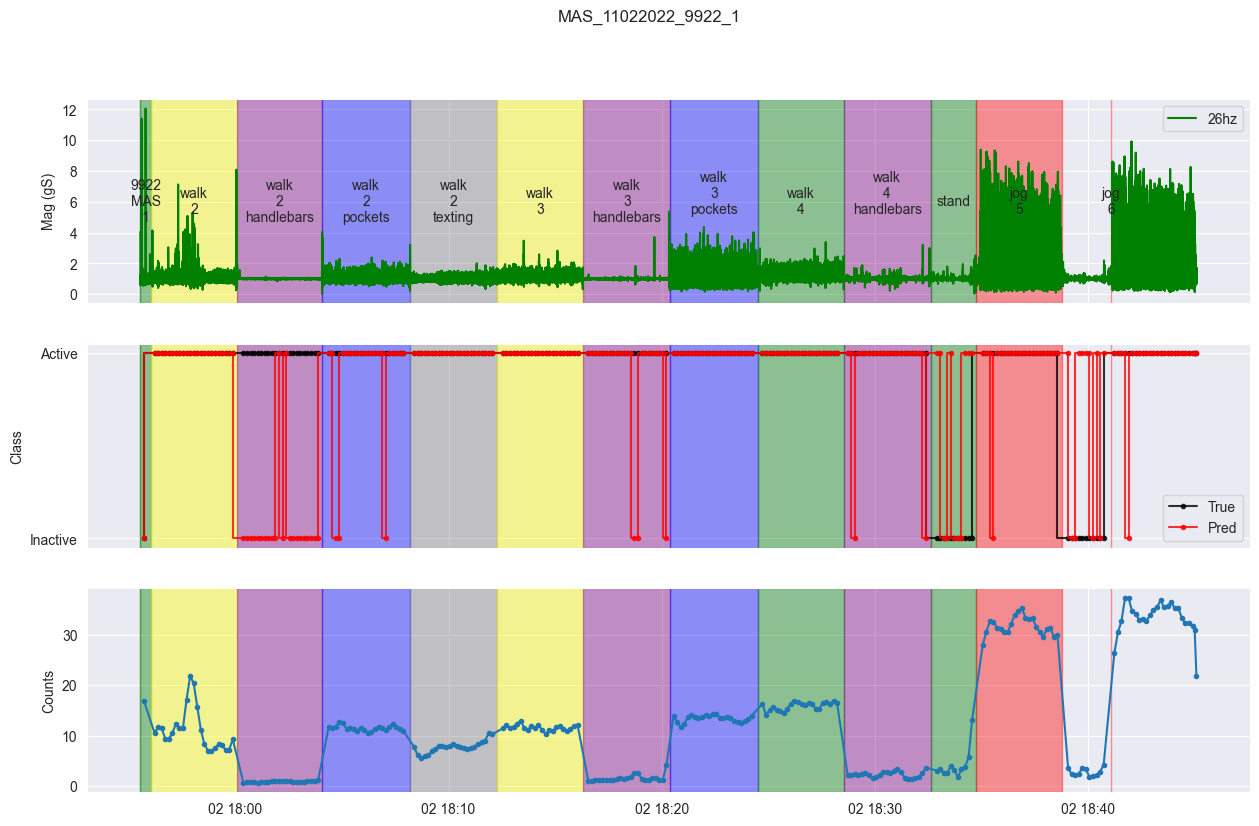

['/Users/lselig/Desktop/MAS/MAS_11022022_1234_1/Polar_H10/', '/Users/lselig/Desktop/MAS/MAS_11022022_1234_1/Fitbit/', '/Users/lselig/Desktop/MAS/MAS_11022022_1234_1/eb153200004e/']

1234 MAS 1
1234 MAS 1
1234 MAS 1
1234 MAS 1
1234 MAS 1
1234 MAS 1
1234 MAS 1
1234 MAS 1
1234 MAS 1
1234 MAS 1
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
walk 2
w

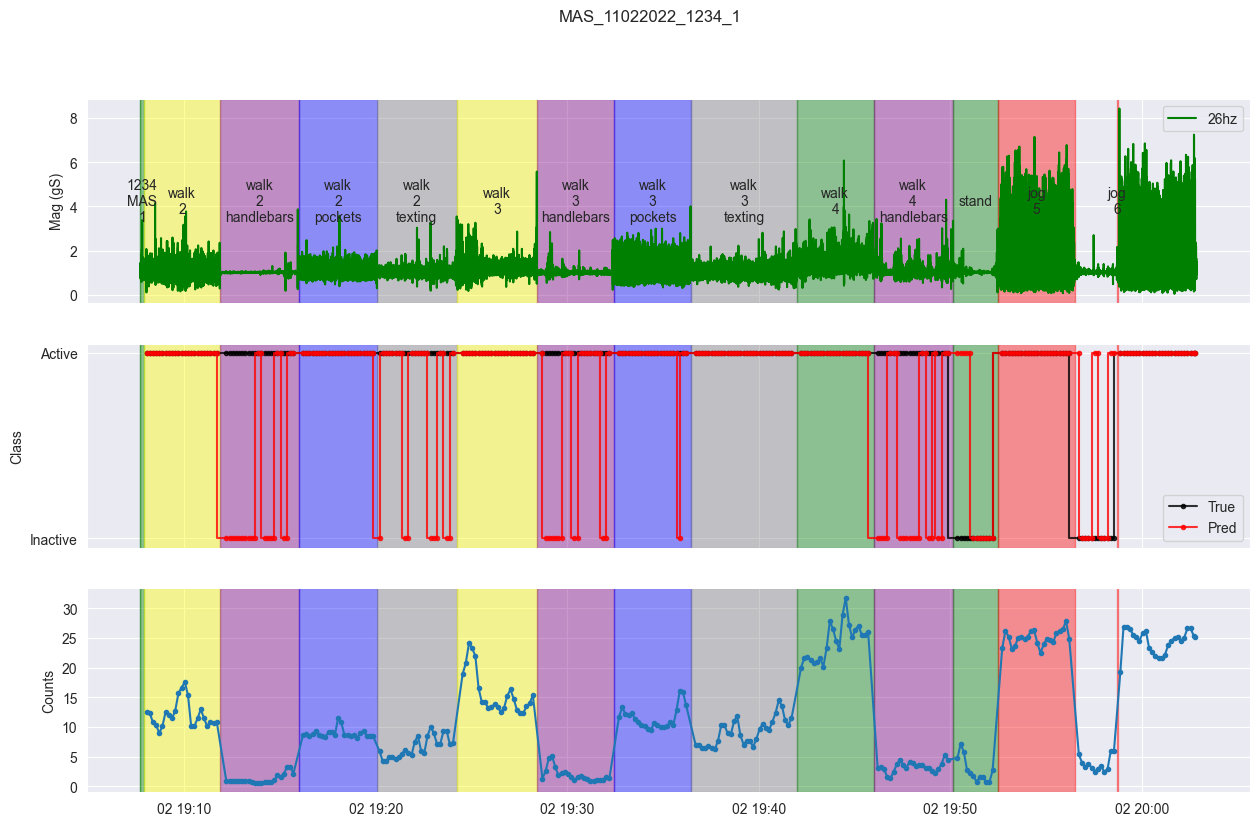

In [109]:

sns.set_style("darkgrid")
for trial in glob.glob("/Users/lselig/Desktop/MAS/*/"):
    # if("9922" not in trial):
    #     continue
    test_trial = trial.split("/")[-2]
    folders = glob.glob(trial + "/*/")
    print(folders)
    ring_folder = None
    for folder in folders:
        if("Polar_H10" not in folder and "Fitbit" not in folder):
            ring_folder = folder
    # test_trial = "HR_ACTIVITY_20210630_282723_827_1"
    df = pd.read_parquet(f"/Users/lselig/Desktop/MAS/{test_trial}/features_labels_v2.parquet")
    acc_26 = pd.read_parquet(f"{ring_folder}/acc.parquet")
    stopwatch = pd.read_csv(f"/Users/lselig/Desktop/MAS/{test_trial}/stopwatch.csv")

    y_df = df.pop(f"true_{MODE}")
    if (MODE == "multi"):
        y_df = y_df.replace( "high", 3 )
        y_df = y_df.replace( "mod", 2 )
        y_df = y_df.replace( "low", 1 )
        y_df = y_df.replace( "inactive", 0 )
    else:
        y_df = y_df.replace( "active", 1 )
        y_df = y_df.replace( "inactive", 0 )

    timestamps = df.pop("etime")
    # df["is_male"] = df["gender"].replace("M", 1).replace("F", 0)
    X_df = df.drop(columns = ["gender", "height_cm", "weight_kg", "age", "true_multi" if MODE == "binary" else "true_binary"])
    # X_df = df.drop(columnsk = ["gender", "true_multi" if MODE == "binary" else "true_binary"])
    y_pred = clf.predict(X_df)
    naxis = 3

    fig, axs = plt.subplots(naxis, 1, figsize = (15, 9), sharex = True )
    axs[0].plot( pd.to_datetime( acc_26.etime, unit = "s" ),
                 np.sqrt( acc_26.x ** 2 + acc_26.y ** 2 + acc_26.z ** 2 ), label = "26hz", color = "green")
    axs[0].set_ylabel( "Mag (gS)" )
    

    seen = []
    for j in range( stopwatch.shape[0] - 1 ):

        label = stopwatch.iloc[j].label
        if(pd.isna(label)):
            label = ""
        print(label)
        if(label not in seen):
            seen.append(label)
        else:
            continue
    
        next_label_idx = j + 1
        for k in range( j + 1, stopwatch.shape[0] - 1 ):
            if (stopwatch.iloc[k].label != label):
                next_label_idx = k
                break

        if("handlebars" in label):
            color = "purple"
        elif("pockets" in label):
            color = "blue"
        elif("texting" in label):
            color = "gray"
        elif ("walk 2" in label or "walk 3" in label):
            color = "yellow"
        elif ("jog" in label):
            color = "red"
        else:
            color = "green"
        for m in range(0, naxis):
            axs[m].axvspan(
                pd.to_datetime( stopwatch.iloc[j].etime, unit = "s" ),
                pd.to_datetime( stopwatch.iloc[next_label_idx].etime, unit = "s" ),
                color = color,
                alpha = 0.4
            )

        mid_x = (stopwatch.iloc[j].etime + stopwatch.iloc[next_label_idx].etime) / 2
        lower, upper = axs[0].get_ylim()
        mid_y = (lower + upper) / 2

        axs[0].text(
            pd.to_datetime( mid_x, unit = "s" ),
            mid_y,
            s = label.replace( " ", "\n" ),
            bbox = {
                        "facecolor": "white",
                        "alpha"    : 0,
                        "edgecolor": "black",
                        "pad"      : 1,
                           },
            ha = "center",
            va = "center",
        )

    y_df_ticks = ["inactive" if x == 0 else "active" for x in y_df]
    y_pred_ticks = ["inactive" if x == 0 else "active" for x in y_pred]
    axs[1].set_ylabel( "Class" )
    axs[1].plot( pd.to_datetime( timestamps, unit = "s" ), y_df, color = "black", alpha = 0.8,
                 label = "True", marker = ".", drawstyle = "steps-pre" )
    axs[1].set_yticks([0, 1])
    axs[1].set_yticklabels(target_names)
    # axs[1].set_yticklabels(y_df_ticks)

    axs[1].plot( pd.to_datetime( timestamps, unit = "s" ), y_pred, color = "red", alpha = 0.8,
                 label = "Pred", marker = ".", drawstyle = "steps-pre" )
    axs[1].legend()

    axs[2].plot( pd.to_datetime( timestamps, unit = "s" ), X_df.counts, marker = "." )
    axs[2].set_ylabel( "Counts" )
    axs[0].legend()
    fig.suptitle(test_trial)
    plt.show()
    plt.close()

In [62]:
# Todo
# windows freq domain for walk 2 handlebards
# repeat random sampling many times and look at results
# LOO on the validation studies
# exclude windows on edges
# add more resting data, walk 2 handlebars
# feature importance for demographics

In [72]:

df = pd.read_parquet("/Users/lselig/Desktop/MAS/MAS_11022022_1717_1/features_labels_v2.parquet")
print(df.shape)
df = pd.read_parquet("/Users/lselig/Desktop/activity_validation_hr_activity_model_dev_v2/HR_ACTIVITY_20210608_1005_512_1/features_labels.parquet")
print(df.shape)

(317, 87)
(384, 87)
